# A Quantitative Analyst's Workflow for AAPL

---

## Section 1 : Why??

Sebelum kita analisis dan buat model, kita perlu ngerti dulu, kenapa kita mau prediksi harga saham AAPL??

### 1.1. Tujuan - Capital Gain & Risk Management

balik ke dasar dalam finance dan investment, invest ke capital market itu tujuannya yang gedein uang kita. nah model disini dipake untuk bantu analisis informasi atau data yang ada dengan lebih efisien dan otomatis. of course model gaakan sempurna, karena pada dasarnya sulit untuk mebemukan pola dalam human behavior penggerak ekonomi. tapi setidaknya ini bisa dijadikan bantuan dalam management investment portofolio kita.

### 1.2. Apa yang Mau di Prediksi??

Kita mau bikin model yang bisa prediksi close value dari AAPL keesokan harinya.  secara simpel itu kaya gini

$Prediksi Harga Besok = fungsi(Data Haei Ini)$

atau :

$Predicted\_Close(t+1) = f(X_t)$



Btw, kita cuma pake data sampe hari ini buat nebak harga besok. Gak boleh tau data besok buat bisa prediksi hari ini, ini disebut lookahead bias, dan ini haram hukumnya di finance modelling.

so, fitur yang kita pake untuk prediksi adalah

- harga pembukaan, tertinggi, terendah, close, dan volume (OHCLC).
- semua data diambil dari data hari hari sebelumnya, sampai hari ini.

### 1.3. Datanya dari mana?? `yfinance` jawabannya

Kita akan menggunakan data harian `OHLCV` (Open, High, Low, Close, Volume) untuk saham 'AAPL', menggunakan `yfinance`. kita bakal ambil data selama 5 tahun terakhir, kenapa 5 tahun?. well, 5 tahun adalah waktu yang udah cukup untuk dapet pola perubahan pasar, naik turun, big event kaya covid dan kenaikan suku bunga. dan juga ga terlalu lama yang bikin data ga relevan ikut masuk dan bikin model bias atau pusing nangkep pola.

#### Dependencies 


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import shap
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Set style background ungu gelap
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

print("Semua library berhasil di-import.")

Semua library berhasil di-import.


#### Data

In [21]:
# ticker dan periode waktu
ticker = 'AAPL'
start_date = '2019-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')

try:
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        raise ValueError("Datanya kosong. Mungkin ticker-nya salah atau gak ada data.")
    print(f"Data {ticker} berhasil diambil dari {start_date} sampai {end_date}.")
    print("\nInformasi umum data:")
    data.info()
except Exception as e:
    print(f"Error ambil data: {e}")

# Drop 'AAPL'
data.columns = data.columns.droplevel(1)  

# Lihat isi data
print("\nLima baris pertama:")
display(data.head())

print("\nStatistik umum:")
display(data.describe())

/var/folders/fz/vv4pwkl920qbrm78wf1yyykr0000gn/T/ipykernel_49435/3107071363.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data AAPL berhasil diambil dari 2019-01-01 sampai 2025-08-05.

Informasi umum data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1656 entries, 2019-01-02 to 2025-08-04
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1656 non-null   float64
 1   (High, AAPL)    1656 non-null   float64
 2   (Low, AAPL)     1656 non-null   float64
 3   (Open, AAPL)    1656 non-null   float64
 4   (Volume, AAPL)  1656 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 77.6 KB

Lima baris pertama:


Price,Close,High,Low,Open,Volume
Date,,,,,
2019-01-02,37.617851,37.839387,36.738862,36.896080,148158800
2019-01-03,33.870838,34.711713,33.825578,34.297229,365248800
2019-01-04,35.316753,35.385836,34.254347,34.428238,234428400
2019-01-07,35.238155,35.452545,34.754593,35.421577,219111200
2019-01-08,35.909908,36.164793,35.378705,35.626440,164101200



Statistik umum:


Price,Close,High,Low,Open,Volume
count,1656.000000,1656.000000,1656.000000,1656.000000,1.656000e+03
mean,142.056409,143.513961,140.449428,141.915690,9.090208e+07
std,56.678442,57.169027,56.136236,56.640183,5.153349e+07
min,33.870838,34.711713,33.825578,34.297229,2.323470e+07
25%,109.021776,110.601815,107.022977,109.330968,5.541982e+07
50%,146.854179,148.457199,145.377281,146.609231,7.780505e+07
75%,181.560982,183.556605,180.132587,181.426782,1.089822e+08
max,258.396667,259.474086,257.010028,257.568678,4.265100e+08


**Analisis :**

Nah, karena projek kita itu buat model yang bisa nebak saham di masa depan. langkah awal yang harus kita lakukan adalah kenalan sama datanya. Ga bagus kalo lansung kasi makan model, karena model itu butuh data yang bagus. Jadi, kita harus lakukan analisis data terlebih dahulu.

Nah, Untuk datanya itu lumayan banyak 1653 data, sekitar 6.5 tahun transaksi harian. jadi dari segi jumlah data ini udah cocok banget.

Nah, pas kita cek harga-harga sahanya. ternyata stabil di angka 141 an buat harga closenya. harga open, high dan lownya juga main di antara situ, gak beda jauh. Tapi jangan sampe tertipu, karena walaupun rata arata ini keliatan oke oke aja, ternyata range harganya beda jauh. Harga paling rendah itu di 33, sedangkan paling tinggi itu di 258. IQR atau Interquartile Ration yang biasa ngukur range data, juga menyimpulkan range nilai yang lebar sekitar 70 point. Tapi sebenarnya ini make sense, namanya capital market, hari ini harganya biasa aja, besoknya bisa aja naik atau turun tajam. Kalo emang valid kenapa di permasalahain??. model itu belajar baik dari data yang range nya itu ga terlalu jauh, untuk sekarang let say itu bisa bikin bias. untuk teknis nya nanti dijelasin lebih dalem. so dari data kita yang punya range nilai yang jauh, kita cuman perlu ubah range nya aja dengan normalisasi. again, nanti kita bahas lebih jauh.

Terus juga kalo diliat, volume transaksi per hari, rata rata ada di 90 jt lembar saham di transaksikan per hari. artinya apa bang messi?. artinya ini saham likuid banget, alias gampang di cairing, cashflownya lancar. ga kaya saham gorengan yang sepi, dan bikin nyangkut. walau volume rata rata tinggi, kasusnya sama kaya harga close harian, range nya fluktuatif banget, minimum vol per hari itu ada di 23 jt, paling tinggi ada di 400 jt. artinya ada beberapa hari yang ga terlalu banyak volume penjualan nya, ada beberapa hari yang tinggi banget penjualannya. Again itu make sense dan normal. tapi untuk model kita perlu ubah range nilai ini, kita ga ubah nilai nya cuman di transformasikan secara merata ke seluruh data. 

Terakhir kita bisa baca dan imagine persebaran daatnya. dari median harga penutupan yang lebih tinggi dari mean, ini tuh pola yang umum untuk data yang left skewed, alias lebih banyak harga rendah yang dominasi. atau dengan kata lain data ga terdistribusi dengan baik. 

Intinya : Datanya valud, lengkap dan bagus. Sahamnya likuid dan volatilitas tinggi. sangat cocok buat bahan modelling. tapi ya iyu, sebelum masuk ke tahap modelling kita perlu benerin persebaran data dan scaling data jadi range yang lebih sempit. Intinya biar model ga pusing kepalanya pas belajar nanti. 


	Daily Range: High - Low → indikator volatilitas harian
	•	Price Change: Close - Open → arah pergerakan harian
	•	Body Ratio: (Close - Open) / (High - Low) → bentuk candlestick
	•	Normalized Volume: (Volume - mean) / std → volume outlier detection
	•	Lag Features: Harga & volume kemarin, 3 hari lalu, 7 hari lalu, dst.

---

## Section 2 : EDA

EDA atau exploratori data analysis adalah menganalisa data, artinya kita peke metode statistik dan analisis lainnya untuk memahami data, seperti bagaimana data terdistribusi, tren paarnya itu gimana, analisis statistik untuk dapetin informasi statistik Inferensi (tiem series, sequential).

### 2.1. Handling Null Values

In [22]:
data.isnull().sum()

Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

lucky me gaada missing value, lets just move on

### 2.2. Grafik Harga Historis dan Valume

kita bakal bikin grafik harga penutupan (Close) dan volume perdagangan pada hari itu, dan kemudian melihat pola yang ada. 

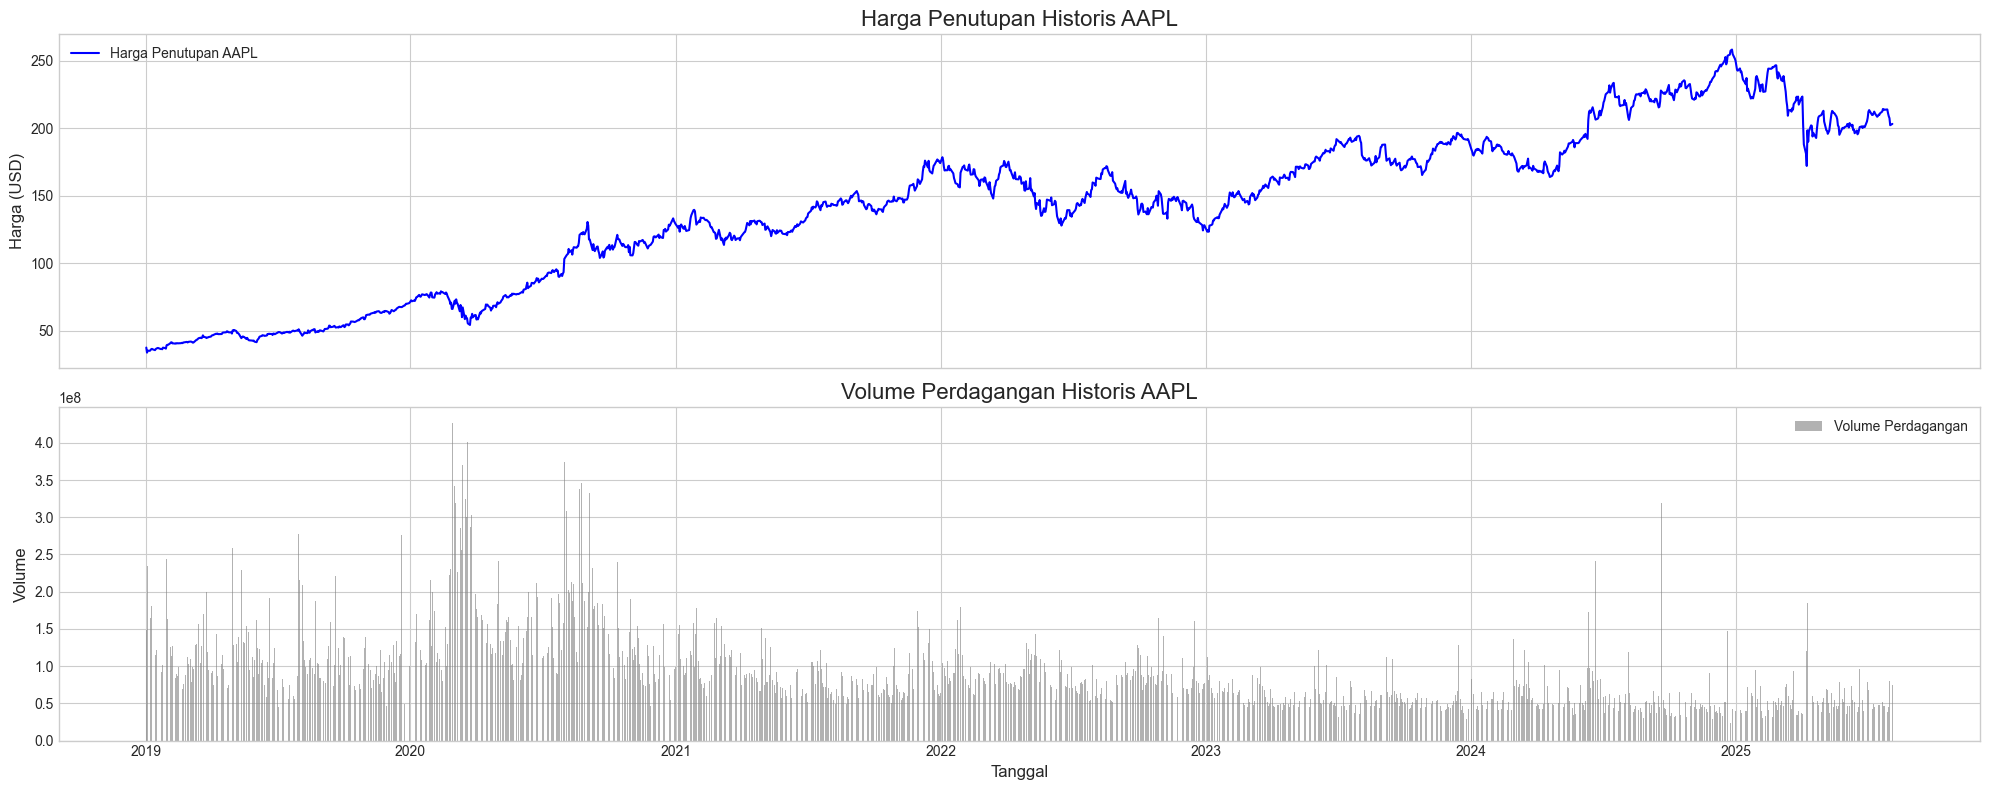

In [23]:
# Membuat plot untuk harga penutupan dan volume perdagangan
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), sharex=True)

# Plot Harga Penutupan (Close)
ax1.plot(data['Close'], label='Harga Penutupan AAPL', color='blue')
ax1.set_title(f'Harga Penutupan Historis {ticker}', fontsize=16)
ax1.set_ylabel('Harga (USD)', fontsize=12)
ax1.legend()

# Plot Volume Perdagangan
ax2.bar(data.index, data['Volume'], label='Volume Perdagangan', color='gray', alpha=0.6)
ax2.set_title(f'Volume Perdagangan Historis {ticker}', fontsize=16)
ax2.set_ylabel('Volume', fontsize=12)
ax2.set_xlabel('Tanggal', fontsize=12)
ax2.legend()

plt.tight_layout()
plt.show()

**Analisis :**

Kenapa analisis kita mulai dari Grafik Tren Harga sama Volume Perdagangan? 

Karena kita ingin memahami bagaimana tren harga saham AAPL bergerak dalam waktu yang jangka panjang, dan bagaimana volume perdagangan mempengaruhi tren tersebut. Grafik ini memberikan gambaran visual dari keduanya, yang dapat digunakan untuk mengidentifikasi pola, tren, dan anomali dalam data. Ini sama aja kaya kita bisa liat detak jantung saham AAPL—biar tau dia lagi sehat, demam, atau rollercoaster.

Yang pertama, grafik close. Kalau kita liat dari ujung ke ujung, trennya jelas banget naik, dari sekitar tahun 2018-2019yang masih di bawah 50 usd, sedikit demi sedikit naik, waalau ada sedikit korelasi di awal tahun 2020, yang mana kita tahu itu masa corona. ekonomi dunia lagi berantakan. banyak yang likuidasi saham AAPL karena panik dan butuh duit buat pasokan makanan di rumah aja. tapi abis itu, langsung ngegas lagi. walau ada beberapa lonjakan yang cukup tajam, tapi overall, arahnya jelas, naik. nih saham kaya daki gunung, ujungnya puncak, tapi kadang harus turun naik dulu buat sampe. 

Disini ada yang menarik, mulai masuk ke tahun 20204, pergerakan mulau agak ga jelas, naik turun, walau ga setegas sebelumnya, tapi ini kaya  lagi nyarah, ada satu puncak yang tinggi banget, tapi sebenatar aja turun lagi dan stabil lagi. Kenapa ini penting?. karena kita bisa bikin asumsi awal kalo sentimen market mulai berubah, mungkin saham udah mulai capek naik. jadi untuk model prediksi nanti, kita bisa pertimabnagan analisis ini. intinya kita bisa feature engeneering, yaitu sentimen market. harapannya kita bisa bikin model lebih bagus belajar.

Sekarang, kita move ke grafik volume penjualan, ini grafik ga kalah penting, dari sini kita bisa buktiin analisis sebelumnya kalo volume transaksi perhari itu sangat gak stabil, ada beberapa hari yang meledak sampe 400jt ada yang dikit doang kaya 40jt. 

Yang lebih menarik lagi, lonjakan itu ga selalu berhubungan dengan kenaikan atau penurunan grafik harga. kadang ada penjualan yang banyak, tapi harganya gak ngraise. Ini tandanya, bisa jadi ada aksi profit taking besar besaran, atau panic sell. so intinya bukan soal harga naik = volume rame. Dari sini kita harus bisa baca emosi atau sentimen pasar yang mempengaruhi volume ini.

Jadi Kesimpulannya : Dari dua grafik kita dapat insight kalo, harga naik drastis, tapi makin ke belakang makin loyo. Volume juga ga stabil di awal awal, walau makin kesini makin stabil. Untuk ini, sebelum masu kmodelling, kita bisa pake insight ini buat menyiapkan fitur yang lebih tajam dan ngasih pola yang lebih jelas. Misal kaya moving average, rolling volatility, atau bahkan momentum.


### 2.3. Decomposisi Time Series

Dekomposisi disini aritnya kita lebih dalem ngebongkar isi dari grafik harga. Seperti tren, seasonality, dan residual.

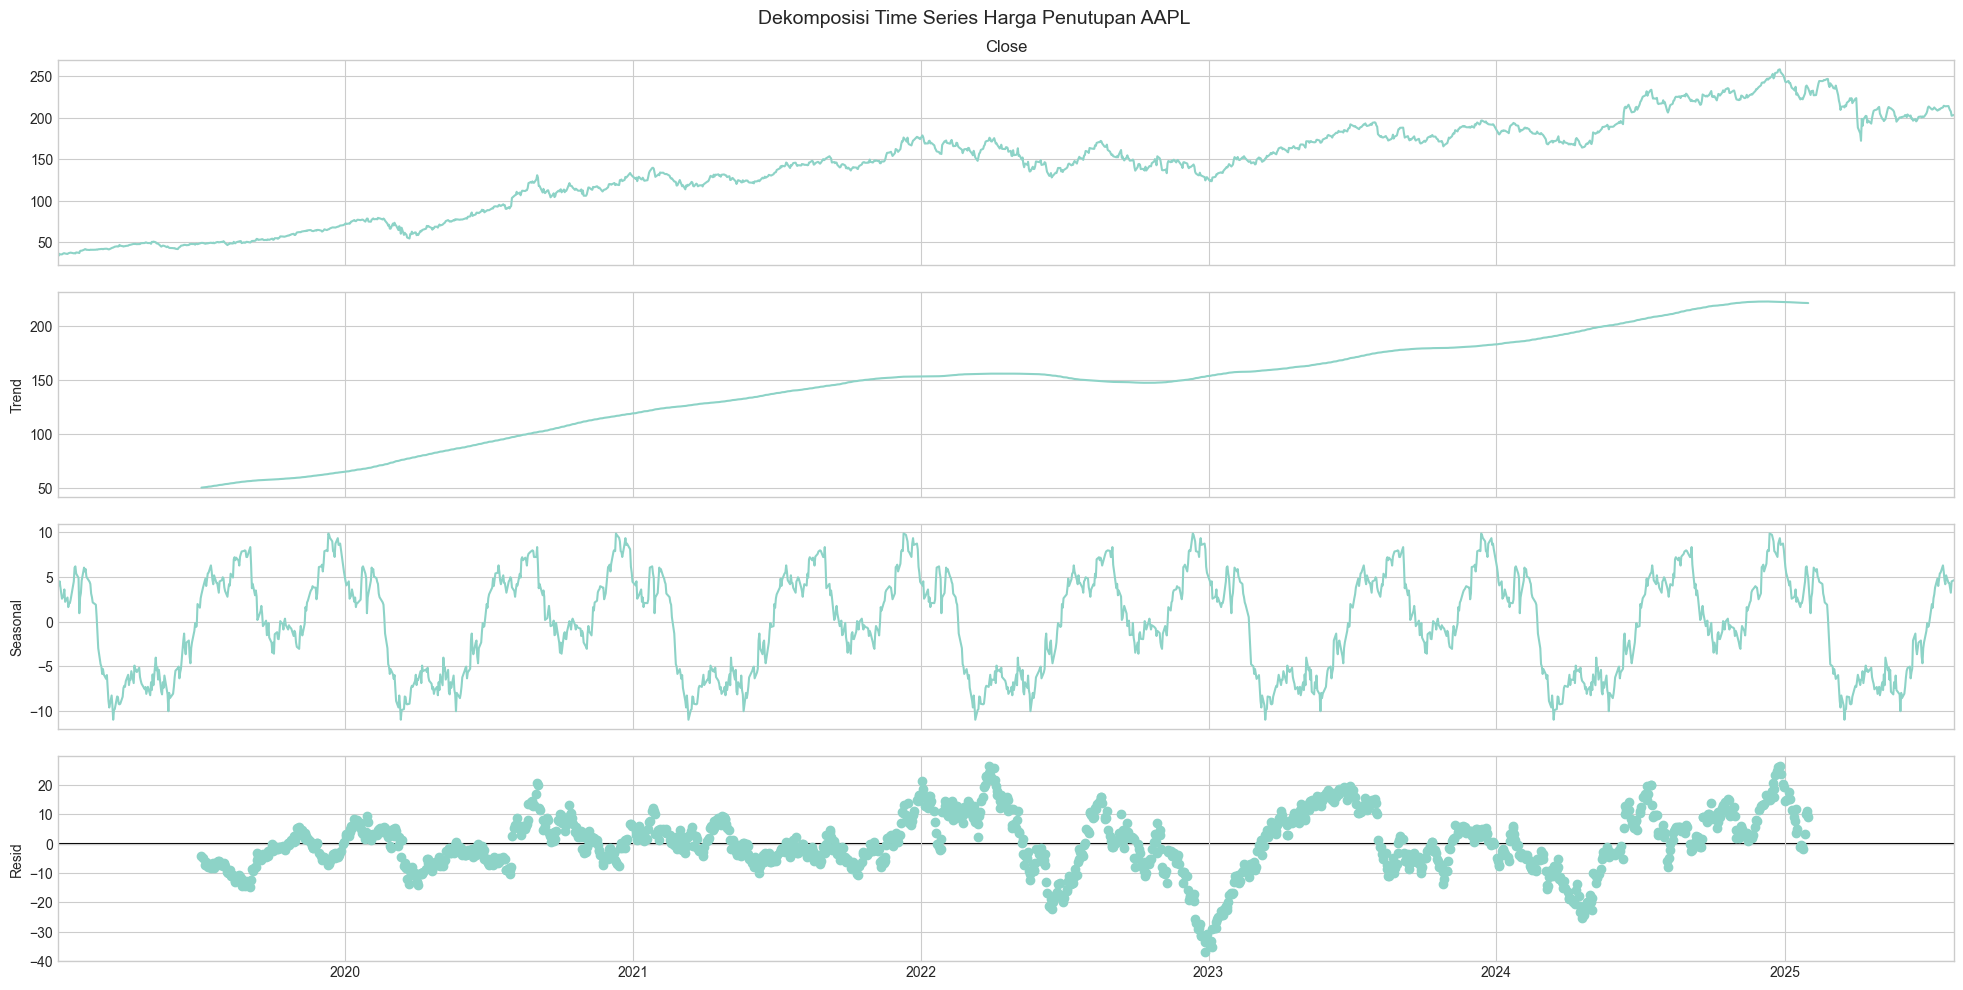

In [24]:
# Melakukan dekomposisi time series menggunakan model aditif
# Kita menggunakan periode 252 (jumlah hari perdagangan dalam setahun) untuk melihat siklus tahunan
decomposition = seasonal_decompose(data['Close'], model='additive', period=252)

fig = decomposition.plot()
fig.set_size_inches(20, 10)
plt.suptitle('Dekomposisi Time Series Harga Penutupan AAPL', y=1, fontsize=14)
plt.show()

**Analisis :**

Kalo lihat harga mentah itu ibaratnya kita liat aliran darah perusahaan, dekomposisi kaya liat dna, apa yang mempengaruhi pergerakan lebih detail. 

Yang paling atas, panel Observed, itu ya grafik asli harga penutupan AAPL. Udah kita liat sebelumnya: naik terus dari 2019, sempet goyang karena COVID, terus lanjut ngebut, dan mulai stabil atau sideways di 2024 ke atas. Nah dari sini aja kita bisa nebak ada sesuatu di balik pola ini — dan itu yang mau kita cari tahu lewat decomposisi.

Lanjut ke panel kedua: Trend. Ini bagian favorit gue, karena dia nunjukin ke mana arah harga secara umum dalam jangka panjang. Di sini keliatan banget harga AAPL tuh punya tren naik yang konsisten dari 2019 sampai 2024 awal. Tapi menariknya, pas 2024-2025, tren mulai datar. Ini ngasih sinyal: mungkin saham ini udah mulai “lelah”, atau pasar lagi ragu-ragu. Dan info kayak gini tuh penting banget buat model prediksi, karena bisa bantu lo nentuin apakah sekarang waktu yang tepat buat beli, tahan, atau cabut.

Lanjut ke bagian Seasonal. Nah ini bagian yang nunjukin pola musiman — alias kebiasaan harga yang berulang dalam periode waktu tertentu. Di sini keliatan banget, tiap tahun AAPL punya semacam siklus naik-turun yang mirip-mirip polanya. Mungkin ada hubungannya sama event tahunan kayak rilis produk baru, laporan keuangan, atau isu musiman lainnya. Pola seasonal ini penting banget kalau lo mau bikin model prediksi jangka pendek, karena bisa bantu lo nangkep momen yang “biasa terjadi”.

Terakhir, Residual. Ini sisa-sisa pergerakan yang gak bisa dijelaskan sama tren atau musiman. Gampangnya, ini bagian “random”-nya pasar — noise, kejadian tak terduga, atau emosi kolektif investor. Residual yang gede artinya harga lagi banyak dipengaruhi hal-hal di luar pola biasa. Di grafik ini, kita bisa liat residual mulai makin “liar” di tahun-tahun belakangan. Artinya pasar makin unpredictible — dan ini tantangan tersendiri buat model nanti.

Jadi intinya, lewat decomposisi ini kita gak cuma liat harga naik atau turun, tapi kita ngerti kenapa dia bisa gitu:
- Naiknya karena tren jangka panjang,
- geraknya naik turun karena musim atau siklus tertentu, dan
- sisanya ya karena dunia ini kadang gak bisa ditebak.


**Analisis**

Grafik atas: Data asli (Close). Itu harga saham AAPL harian dari 2019 sampai 2025. Naik-turun, kelihatan agak random.

Grafik kedua: Trend. Ini kayak kita “mulusin” grafik asli, buat lihat arah jangka panjang. “Kalau dihilangin naik-turun harian, sebenarnya harga AAPL cenderung naik dari waktu ke waktu.”

Grafik ketiga: Seasonality (pola musiman). Ini nunjukin pola yang berulang tiap tahun. “Ada kecenderungan harga AAPL ngalamin siklus naik-turun setiap tahun. Tapi bisa jadi ini cuma pola statistik, bukan peluang cuan pasti.”

Grafik keempat: Residual (sisa). Ini sisa-sisa yang nggak bisa dijelaskan sama trend atau seasonality.

### 2.4. Stasioneritas: Uji Augmented Dickey-Fuller (ADF)

Intinya uji ADF adalah untuk ngecek apakah data kita stasioner atau tidak. stasioner sendiri adalah sifat statistik data yang tidak berubah seiring waktu. kestabilan data. saham itu biasanya non stasioner karena biasa ada tren. 

Lebih simpelnya kita bisa anggap ini kayak ngecek apakah data saham kita tuh “stabil” atau enggak dalam jangka panjang — karena banyak model prediksi kayak ARIMA atau yang lain itu cuma bisa kerja kalau data dasarnya stasioner. Ibarat lo lagi ngasih jalur lari ke model, kalau jalannya naik turun kayak gunung, ya dia ngos-ngosan. Tapi kalau datanya stabil alias stasioner, model bisa lari lebih mulus.

Inti ADF Test: 
- Hipotesis nol (H0): Data ini non-stasioner
- Hipotesis alternatif (H1): Data ini stasioner

Interpretasi:
- Kalau p-value > 0.05 → Kita gagal menolak H0 → Data non-stasioner
- Kalau p-value ≤ 0.05 → Kita tolak H0 → Data stasioner

In [25]:
# Simpan harga asli dulu
close_data = data['Close'].copy()

def perform_adf_test(series, series_name):
    """Melakukan dan mencetak hasil Uji ADF."""
    result = adfuller(series.dropna())
    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4]

    print(f'Uji Augmented Dickey-Fuller untuk: {series_name}')
    print(f'ADF Statistic: {adf_stat:.4f}')
    print(f'p-value: {p_value:.4f}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'\t{key}: {value:.4f}')
    
    if p_value <= 0.05:
        print(f'Kesimpulan: Data stasioner (p-value <= 0.05). Kita menolak hipotesis nol.')
    else:
        print(f'Kesimpulan: Data non-stasioner (p-value > 0.05). Kita gagal menolak hipotesis nol.')

# Uji pada harga penutupan asli
perform_adf_test(close_data, 'Harga Penutupan (Original)')

# Uji pada first difference (imbal hasil harian)
# Differencing adalah cara umum untuk membuat data menjadi stasioner
return_data = close_data.pct_change()
perform_adf_test(return_data, 'Imbal Hasil Harian (First Difference)')

Uji Augmented Dickey-Fuller untuk: Harga Penutupan (Original)
ADF Statistic: -1.5511
p-value: 0.5081
Critical Values:
	1%: -3.4343
	5%: -2.8633
	10%: -2.5677
Kesimpulan: Data non-stasioner (p-value > 0.05). Kita gagal menolak hipotesis nol.
Uji Augmented Dickey-Fuller untuk: Imbal Hasil Harian (First Difference)
ADF Statistic: -13.2904
p-value: 0.0000
Critical Values:
	1%: -3.4343
	5%: -2.8633
	10%: -2.5677
Kesimpulan: Data stasioner (p-value <= 0.05). Kita menolak hipotesis nol.


**Analisis :**

Pas kita tes data harga penutupan yang asli, nilai p-value-nya 0.5039. Itu tinggi banget. Artinya? Kita gagal nolak hipotesis nol, alias kita anggap datanya non-stasioner. Gampangnya, harga saham itu bergerak secara acak dan punya tren jangka panjang. Nggak bisa ditebak dengan pola yang tetap tiap hari. Tapi ini wajar banget, karena harga saham emang cenderung non-stasioner secara alami.

Tapi pas lo ubah datanya jadi imbal hasil harian — alias selisih harga hari ini sama kemarin — BOOM! Nilai ADF statistic-nya jadi -13.28 dan p-value-nya 0.0000. Itu udah kaya lampu merah terang benderang buat nolak hipotesis nol. Artinya? Data udah stasioner.

Kenapa ini penting? Karena sekarang kita punya dasar yang kuat buat lanjut ke modeling. Kita tahu bahwa data harga aslinya terlalu liar buat dimodelin langsung, tapi kalau kita ubah jadi return harian, data itu jadi lebih stabil dan bisa “dicerna” sama model. Lo kayak ngasih makanan keras ke blender — kerasnya dipecah dulu jadi halus baru bisa dibentuk jadi smoothie prediksi yang enak.



Kesimpulannya, tahap ini ngasih kita insight penting:
- Harga saham mentah gak stabil — ngikutin tren, noise, dan emosi pasar.
- Tapi kalau kita lihat pergerakan hari ke harinya (return), itu jauh lebih rapi dan bisa dipelajari.
- Dan yang paling penting, ini nentuin kita mau modeling harga langsung (dengan teknik yang tahan tren kayak LSTM) atau modeling return-nya dulu (kayak ARIMA, dll).

### 2.4 Memori Pasar: Analisis Autokorelasi (ACF) dan Autokorelasi Parsial (PACF)

Reminder, tadi kita udah ngomongin soal stationarity, yaitu soal apakah harga saham ini punya pola atau tren yang nempel dari waktu ke waktu? Nah, ADF test udah ngasih tau jawabannya: harga aslinya belum stasioner, tapi begitu kita ubah jadi return harian alias selisih harga dari hari ke hari, datanya jadi stasioner. Artinya, setelah kita buang tren jangka panjang, data return-nya udah stabil dan siap dimodelin.

Tapi… kita belum kelar. Soalnya kita belum tau seberapa panjang ingatan si pasar ini. Ingatannya tuh kayak gimana sih? Harga hari ini dipengaruhi seberapa besar sama harga kemarin, dua hari lalu, seminggu lalu? Atau jangan-jangan, dia gak inget apa-apa dan semua cuma random?

Makanya kita pake dua alat: ACF dan PACF. Ini dua grafik yang fungsinya ngulik pola hubungan waktu dalam data.


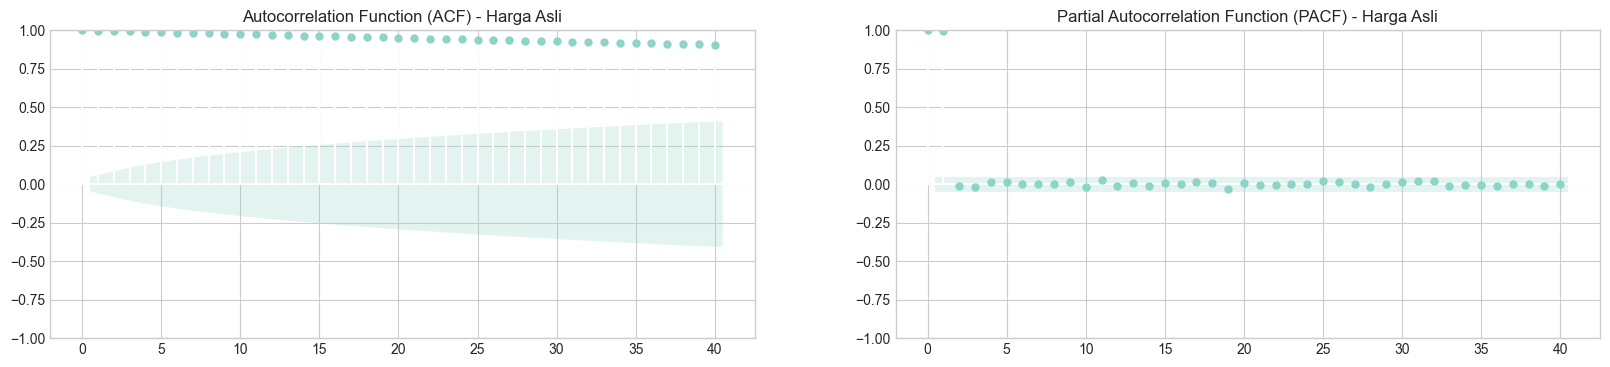

In [31]:
# Plot ACF dan PACF pada harga penutupan asli
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

plot_acf(close_data.dropna(), ax=ax1, lags=40)
ax1.set_title('Autocorrelation Function (ACF) - Harga Asli')

plot_pacf(close_data.dropna(), ax=ax2, lags=40)
ax2.set_title('Partial Autocorrelation Function (PACF) - Harga Asli')

plt.show()

**Analisis :**

**ACF - Harga Asli**

Gambarnya kayak tiang-tiang yang tinggi banget di awal terus menurun pelan-pelan. Ini nunjukin satu hal penting: harga saham yang kita analisis ini punya memori panjang. Harga hari ini masih ada hubungannya sama harga 2 hari lalu, 10 hari lalu, bahkan 40 hari lalu. Ini klasik banget buat data harga yang belum di-difference, karena tren jangka panjang masih ngasih efek.

Artinya?
Kalau kita modelin langsung harga ini tanpa preprosesing, kita bakal dapet model yang “ditipu” oleh tren. Dia bakal kira ada hubungan kuat, padahal itu cuma karena harga pelan-pelan naik dari tahun ke tahun, bukan karena hubungan hari ke hari.

**PACF - Harga Asli**

PACF itu lebih picky, dia cuma mau ngasih tau hubungan langsung antara hari ini dan masa lalu. Dan pas kita lihat grafik ini, hampir semua titik datarnya minta ampun, kayak gak ada yang menonjol. Artinya? Gak ada hubungan langsung yang kuat antar harga dari hari ke hari. Ini makin nekenin bahwa tren yang tadi kita lihat di ACF bukan karena hubungan satu hari ke hari berikutnya, tapi efek panjang dari tren global.

Dalam konteks modeling, ini sinyal bahwa kita gak bisa langsung main AR (AutoRegressive) di harga asli, karena gak ada korelasi jangka pendek yang bisa dipelajari. PACF bilang: “Bro, data kita kayak laut yang tenang di permukaan, tapi sebenernya ada arus deras di bawahnya—itu tren.”

Nah, dua grafik itu tadi ngelihat harga asli. Sekarang kita beralih ke data yang udah di-difference alias udah dibikin jadi return harian. Ini langkah penting buat bikin data stasioner, dan… efeknya langsung keliatan jelas.

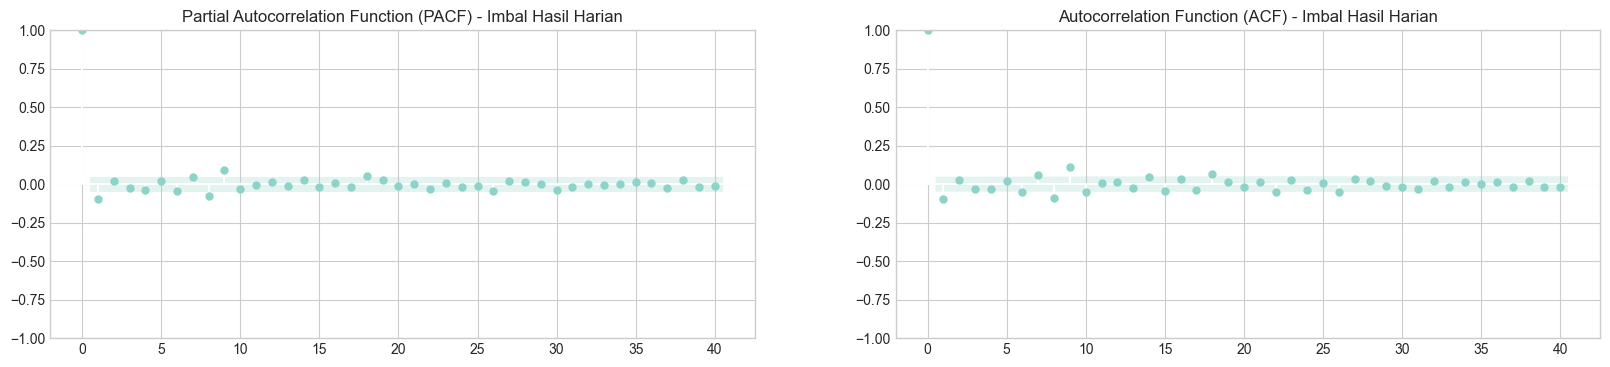

In [32]:
# Plot ACF dan PACF pada data yang sudah di-differencing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

plot_pacf(return_data.dropna(), ax=ax1, lags=40)
ax1.set_title('Partial Autocorrelation Function (PACF) - Imbal Hasil Harian')

plot_acf(return_data.dropna(), ax=ax2, lags=40)
ax2.set_title('Autocorrelation Function (ACF) - Imbal Hasil Harian')

plt.show()

**Analisis**

**ACF - Return Harian**

Berbeda dari harga asli yang grafik ACF-nya tinggi dan pelan turun, grafik ACF di sini kayak benteng yang roboh. Spike tinggi cuma di lag 1 (hari kemarin), setelah itu anjlok dan mendekati nol. Ini artinya: harga hari ini cuma punya hubungan sama harga kemarin, selebihnya udah gak relevan.

Ini keren, karena dia nunjukin bahwa model moving average (MA) mungkin cocok buat data return ini. MA itu model yang bilang “eh, error hari ini bisa dijelasin dari error kemarin”, dan pola ACF ini cocok banget buat itu.

**PACF - Return Harian**

Nah ini juga menarik. Di grafik PACF, kita bisa lihat spike yang dominan cuma di lag 1, dan setelah itu langsung datar. Ini artinya: hubungan langsung antara return hari ini dan return kemarin tuh ada, tapi gak nyampe lebih dari satu hari.

Interpretasinya?
Model AR(1) alias autoregressive dengan lag 1 mungkin cukup. Gak usah neko-neko sampe AR(5) atau AR(10), karena gak ada sinyal kuat di lag berikutnya.

Jadi intinya gimana semua ini?

Oke, kita punya harga saham yang awalnya punya tren jangka panjang. Itu bikin dia kelihatan seolah-olah punya pola kuat, tapi ternyata setelah dipecah jadi return harian, kita dapet data yang lebih realistis: cuma ada hubungan jangka pendek aja, sehari ke depan.

Analisis ACF dan PACF ini kayak kita lagi ngobrol sama data, nanya: "kamu inget gak sama yang kemarin?"

Dan data jawab, "Yah, aku sih masih inget yang kemarin banget, tapi sisanya… udah agak kabur."

Itu sinyal yang bagus banget buat modeling. kita bisa masuk ke ranah ARIMA (kemungkinan ARIMA(1,1,1) atau ARIMA(0,1,1)), atau kita bisa jadiin ini dasar buat masuk ke LSTM kakita kita mau ekplor neural network.

Soalnya model apapun yang kita pake, dia perlu tau dulu:
- Apakah ada pola?
- Seberapa jauh ingatan datanya?
- Apakah harus fokus ke masa lalu jauh, atau cukup hari kemarin aja?

### 2.5. Hipotesis

Kita udah nyelam lumayan dalam ke data, dari stasioneritas, ACF-PACF, sampe ngebongkar tren lewat dekomposisi. Sekarang saatnya kita tarik nafas, duduk sebentar, terus bilang: “Oke, dari semua yang udah kita lihat, sebenarnya apa sih hal penting yang bisa kita jadiin dasar buat modeling nanti?” Nah itulah gunanya formulasi hipotesis awal ini.

Kita bisa bayangin ini kayak kita lagi ngasih “dugaan awal” sebelum ngeracik ramuan prediksi. Jadi gak langsung nebak-nebak, tapi punya dasar logis yang kuat. 

**Hipotesis 1: Harga saham AAPL non-stasioner dan punya tren naik jangka panjang.**

Kalo kita inget lagi, gimana sih harga asli AAPL kalau kita plot? Itu kayak tanjakan halus yang makin lama makin naik kan?. Dan ini bukan cuma asumsi nguawor rek, ini udah dikuatin juga sama hasil ADF test, di mana p-value-nya gede banget (0.50++), bikin kita gagal menolak hipotesis nol. Artinya: data ini punya tren yang jelas, bukan datar datar aja.

Terus pas kita dekomposisi datanya, juga keliatan jelas komponen tren nya dominan, kayak ngasih tau, “ini data bukan sekedar random naik turun, tapii, ada arah jelas, yaitu ke atas.”

Jadi kenapa ini penting?

Kalau kita langsung modeling data harga aslinya tanpa mengatasi non-stasioneritas, model kita bakal kecolongan sinyal palsu. Modelnya bakal kira dia pinter karena bisa ‘prediksi’ tren, padahal dia cuma ngejar garis lurus doang. Makanya kita harus difference dulu datanya, alias ubah ke return/selisih, biar model gak ketipu tren jangka panjang.

**Hipotesis 2: Harga hari ini adalah penentu terbaik buat harga besok.**

Ini yang kita dapet dari ACF dan PACF tadi. ACF nunjukin memori panjang (karena tren), tapi begitu kita ubah jadi return harian, spike tertinggi dan satu satunya yang signifikan cuman ada di lag 1. Artinya? Harga besok kemungkinan besar cuma dipengaruhi oleh harga hari ini atau paling 1 hari sebelumnya. Sisanya? Gak ngaruh.

PACF juga mendukung. Di data return, cuma lag 1 yang punya korelasi langsung. Setelah itu? Datar kaya hidup hidup lo.

Ini ngasih sinyal kuat bahwa prediktor utama buat harga besok ya... harga sekarang. Simple, tapi kuat. Dan ini juga bantu kita waktu nentuin parameter ARIMA atau ARX model. Kita gak usah ribet mikirin 7 hari ke belakang, cukup 1 atau 2.

So what? ...

Kalau kita bikin model yang ngelatih data pake terlalu banyak lag, kita justru nambah noise. Jadi lebih hemat, lebih presisi kalau kita fokus sama hubungan jangka pendek.

**Hipotesis 3: Volatilitas harga gak konstan—ada ‘cluster’ naik-turun yang ngumpul.**

Nah ini agak tricky tapi penting banget. Waktu kita lihat plot dari residu dekomposisi (sisa setelah tren dan musiman dicopot), lo bakal notice satu hal: residunya gak stabil. Kadang tenang banget, kadang chaos, kayak pasar lagi panik. Ini nunjukin gejala klasik dari yang namanya heteroskedastisitas. alias varians yang gak konstan.

Kita bisa anggap ini kayak cuaca. Kadang pasar kalem banget kayak hari biasa, kadang tiba-tiba badai. Dan inilah kenapa model-model seperti GARCH, atau bahkan neural networks dengan struktur non linear (kayak LSTM), bisa unggul. Karena mereka bisa nangkep pola fluktuasi yang kacau-kacau, sedangkan model linear biasa (ARIMA doang, misalnya) gabisa terlalu fleksibel untuk metain data dengan volatilitas lagi tinggi.

Oleh karena itu.. 

Kalau kita pake model linear biasa, dia bakal ngasih prediksi yang terlalu percaya diri waktu pasar lagi volatile, dan itu bahaya. Tapi kalau lota udah ngerti dari awal bahwa volatilitas ini “ngumpul ngumpul”, lo bisa siapin model yang lebih adaptif.

SOooooo..

dari EDA yang udah kita lakuin, kita bisa bilang:

- Satu, data harga itu masih ‘terjebak masa lalu’ alias tren jangka panjang, dan belum bisa langsung dimodelin. Harus di-difference dulu.
- Dua, setelah kita ‘segarin’ datanya, kita nemu bahwa harga kemarin adalah prediktor terbaik buat harga besok. Sisanya cuma noise.
- Tiga, pasar ini moody, kadang tenang, kadang drama. Dan itu berarti kita butuh model yang ngerti dinamika emosi pasar ini, bukan yang mikir semuanya flat-flat aja.

## Section 3 : Preprocessing and Feature Engineering

Tahap ini kita nyiapin data agar bisa mudah dicerna sama model. 

### 3.1. Null Values

Yang pertama Integritas Data dan Penanganan Kronologis. Ini basic, tapi krusial. Percuma aja kalo model pinter tapi dapet data bocoran dari masa depan, kan?

so.. apa sih maksud dari “integritas data” ini?

Gini… kita bisa bayangin data time series (kayak harga saham ini) itu kayak cerita yang dibacain dari awal sampe akhir. Jadi urutannya harus bener dan gak boleh "bolong bolong". Kalau tiba-tiba ada halaman yang hilang, atau urutannya acak-acakan, model bakal bingung... kayak kita baca novel tapi tiba tiba loncat dari bab 3 ke bab 7. kan konteksnya jadi berantakan buat dipahami.

Makanya hal pertama yang kita cek adalah:

“Ada gak data yang hilang? Dan kalau ada, ngaruh gak ke konteks?”

In [33]:
# Memeriksa nilai yang hilang
print("Jumlah nilai yang hilang per kolom:")
print(data.isnull().sum())

# Menangani missing values jika ada (misalnya, dari hari libur pasar)
data.ffill(inplace=True)
print("\nJumlah nilai yang hilang setelah forward fill:")
print(data.isnull().sum())

Jumlah nilai yang hilang per kolom:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Jumlah nilai yang hilang setelah forward fill:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


**Analisis :**

Kalau kita liat hasil nya, jelas banget:
- Di bagian awal, semua kolom (Price, Close, High, Low, Open, Volume) = 0 nilai yang hilang
- Setelah di-forward fill, ya tetep = 0 juga

Artinya adalah :
- Data kita utuh. Gak ada missing value dari awal. dan 
- Forward fill (`ffill`) gak ngubah apa apa karena emang gak ada yang perlu diisi. Tapi ini tetep langkah yang penting banget. 

Kita mungkin mikir: “Lha ngapain di-ffill kalo gak ada data hilang?” 

Jawabannya: preventif. Jadi semacam jaga-jaga, kalau nanti ada preprocessing lain yang bikin missing (misal: shifting untuk prediksi harga besok), lo udah siap duluan. Ini tuh bagian dari pipeline yang emang default nya gitu, lebih baik gitu dari pada gaada

Kenapa forward fill? Emangnya gak bisa pakai metode lain?

Nah, ini penting nih. Di time series, kita gak boleh ngisi missing value sembarangan, kayak rata rata atau interpolasi dua arah. Kenapa? Karena itu kayak kita bawa info dari masa depan buat nutupin masa lalu. dan itu cheating.

Makanya kita pilih forward fill (ffill), yang intinya:

“Kalau hari ini gak ada data, pake aja data terakhir yang tersedia.”

Itu lebih realistis dan gak bocorin masa depan. Ini juga lumrah banget di dunia finansial, karena pasar kadang emang gak buka (weekend, libur), dan data suka bolong. jadi isi hari itu dengan hari sebelumnya masih masuk akal banget.

So what? Kenapa ini penting buat modeling nanti?

Ginii... model machine learning itu gak ngerti konteks pasar. Dia cuma ngerti angka. Jadi kalau kita kasih data yang acak acakan atau ada bolongan, dia bakal bikin kesimpulan yang nguawor rek juga. Nah, dengan data yang utuh dan kronologis atau konteks yang rapi, kita ngasih fondasi kuat ke model, biar dia bisa belajar dengan baik tanpa distraksi atau bias.

Kesimpulan : 

Data kita aman, bersih, gak ada bolong. Forward fill udah dijalanin sebagai tameng otomatis, walaupun belum kepake sekarang. Ini ngebuktiin kita peduli banget sama urutan dan alur cerita data, gak asal kasih makan ke model.

### 3.2. Feature Engeneering

Secara simpel: kita lagi ngubah masalah time series (deret waktu) jadi masalah supervised learning.

Artinya: kita pengen model lo belajar dari masa lalu buat nebak masa depan.

Makanya kita perlu bikin fitur-fitur alias X (input) buat nebak harga masa depan alias Y (output).

Caranya?

Kita ambil info dari data sebelumnya: harga kemarin, minggu lalu, pola rata-rata, volatilitas, dll.

Penjelasan Fitur-Fitur yang Dirancang

#### 3.2.1. Lag Features (`lag_1`, `lag_2`, ...)

Ini fitur paling basic tapi sering paling ngaruh.

Intinya, kita bilang ke model:

“Eh, harga kemarin tuh segini loh. kira-kira besok bakal gimana?”

Misalnya `lag_1` itu artinya harga 1 hari sebelum hari ini. `lag_2` artinya 2 hari sebelumnya, dst.

Buat apa? Karena di pasar, harga hari ini biasanya gak lompat jauh dari harga kemarin. Ada kontinuitas. Jadi fitur ini kayak momentum jangka pendek.

Dan kaya yang kita liat di PACF sebelumnya, `lag_1` kemungkinan besar jadi prediktor paling kuat.

In [ ]:
# Ambil kolom 'Close' aja, pakai [[]] supaya tetap jadi DataFrame (bentuk tabel 2D, bukan Series 1D).
# .copy() supaya perubahan di df nggak ngubah data aslinya.
df = data[['Close']].copy()

df.head()

Price,Close
Date,
2019-01-02,37.617851
2019-01-03,33.870838
2019-01-04,35.316753
2019-01-07,35.238155
2019-01-08,35.909908


In [ ]:
# Fitur Lag – nyimpan info harga dari beberapa hari sebelumnya.
# shift(i) artinya geser harga ke bawah sebanyak i baris (i hari lalu).
for i in range(1, 6):  # 1 sampai 5 hari ke belakang
    df[f'lag_{i}'] = df['Close'].shift(i)
    # Contoh: [100, 102, 105, 103, 108] → shift(1) → [NaN, 100, 102, 105, 103]

df.head()

Price,Close,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2019-01-02,37.617851,NaN,NaN,NaN,NaN,NaN
2019-01-03,33.870838,37.617851,NaN,NaN,NaN,NaN
2019-01-04,35.316753,33.870838,37.617851,NaN,NaN,NaN
2019-01-07,35.238155,35.316753,33.870838,37.617851,NaN,NaN
2019-01-08,35.909908,35.238155,35.316753,33.870838,37.617851,NaN


#### 3.2.2. Moving Averages (`ma_7`, `ma_30`, `ma_90`)

Ini semacam indikator tren : 
- `ma_7` = rata-rata harga 7 hari terakhir
- `ma_30` = rata-rata 30 hari
- `ma_90` = rata-rata 90 hari

Kenapa 3 periode ini?

Karena mereka ngasih gambaran tentang tren jangka pendek (`ma_7`), menengah (`ma_30`), dan jangka panjang (`ma_90`).

Gampangnya:
- Jika harga sekarang di atas rata-rata 30 hari, kemungkinan lagi bullish.
- Kalau di bawah? Bisa jadi bearish.
- Dan moving average ini juga sering dijadiin indikator support/resistance dinamis di dunia trading.

In [49]:
# Moving Average – buat nangkep tren harga dalam jangka pendek sampai panjang.
# .rolling(window=n) artinya ambil n hari ke belakang dari posisi sekarang, lalu hitung nilai tertentu (mean/std).
df['ma_7'] = df['Close'].rolling(window=7).mean()     # MA 7 hari – tangkep tren jangka pendek
df['ma_30'] = df['Close'].rolling(window=30).mean()   # MA 30 hari – tren menengah
df['ma_90'] = df['Close'].rolling(window=90).mean()   # MA 90 hari – tren panjang
df.tail()

Price,Close,lag_1,lag_2,lag_3,lag_4,lag_5,ma_7,ma_30,ma_90,volatility
Date,,,,,,,,,,
2025-07-29,211.270004,214.050003,213.880005,213.759995,214.149994,214.399994,213.427141,207.793667,205.611386,5.879988
2025-07-30,209.050003,211.270004,214.050003,213.880005,213.759995,214.149994,212.937143,208.148000,205.558390,5.609720
2025-07-31,207.570007,209.050003,211.270004,214.050003,213.880005,213.759995,211.961430,208.545667,205.442677,5.091371
2025-08-01,202.380005,207.570007,209.050003,211.270004,214.050003,213.880005,210.280003,208.739000,205.242001,4.717745
2025-08-04,203.350006,202.380005,207.570007,209.050003,211.270004,214.050003,208.792862,208.817334,205.018590,4.602928


#### 3.2.3. `rolling_std_30` (Rolling Standard Deviation)

Ini fitur buat ngukur seberapa “liar” pergerakan harga dalam 30 hari terakhir.

- Kalau deviasinya gede -> harga lagi gak stabil -> tingkat risiko tinggi
- Kalau deviasinya kecil -> harga cenderung tenang -> risiko rendah

Jadi fitur ini ngebantu model buat ngukur ketidakpastian, semacam ngasih feeling:

“Wah, pasar lagi gerak ekstrim nih, jangan asal nebak.”

In [50]:
# Volatility (rolling standard deviation) – seberapa besar harga berfluktuasi dalam 30 hari terakhir.
# Kalau harga banyak menyimpang dari rata-rata, std bakal besar → berarti volatile.
df['volatility'] = df['Close'].rolling(window=30).std()
df.tail()

Price,Close,lag_1,lag_2,lag_3,lag_4,lag_5,ma_7,ma_30,ma_90,volatility
Date,,,,,,,,,,
2025-07-29,211.270004,214.050003,213.880005,213.759995,214.149994,214.399994,213.427141,207.793667,205.611386,5.879988
2025-07-30,209.050003,211.270004,214.050003,213.880005,213.759995,214.149994,212.937143,208.148000,205.558390,5.609720
2025-07-31,207.570007,209.050003,211.270004,214.050003,213.880005,213.759995,211.961430,208.545667,205.442677,5.091371
2025-08-01,202.380005,207.570007,209.050003,211.270004,214.050003,213.880005,210.280003,208.739000,205.242001,4.717745
2025-08-04,203.350006,202.380005,207.570007,209.050003,211.270004,214.050003,208.792862,208.817334,205.018590,4.602928


#### 3.2.4. `momentum_oscillator`

Ini formula-nya:

```
momentum_oscillator = (ma_7 / ma_30) - 1
```

Artinya, ini ngebandingin momentum jangka pendek vs jangka menengah.
- Kalau nilainya positif -> `MA_7` lebih tinggi -> momentum jangka pendek kuat -> bisa jadi sinyal naik.
- Kalau negatif -> `MA_7` di bawah `MA_30` -> momentum lemah -> bisa jadi sinyal turun.

Fitur ini tuh kayak indikator RSI versi simple. Dia bantu model paham:

“Lagi ada dorongan kuat gak sih buat naik/turun sekarang?”

In [ ]:
# Momentum Oscillator – indikator arah dan kekuatan tren.
# Bandingkan MA pendek (ma_7) dengan MA panjang (ma_30):
# - Kalau hasil positif → harga lagi naik
# - Kalau negatif → harga cenderung turun
# - Kalau 0 → harga stagnan (ma_7 = ma_30)
df['momentum_oscillator'] = (df['ma_7'] / df['ma_30']) - 1

# Hapus baris awal yang punya NaN karena rolling & lag butuh cukup banyak data dulu.
df.dropna(inplace=True)

# Tampilkan hasil akhir dengan semua fitur
df.head()

Price,Close,lag_1,lag_2,lag_3,lag_4,lag_5,ma_7,ma_30,ma_90,volatility,momentum_oscillator
Date,,,,,,,,,,,
2019-05-10,47.353004,48.018230,48.539745,48.530182,49.874653,50.656937,49.001099,48.205701,43.027265,1.291560,0.016500
2019-05-13,44.600868,47.353004,48.018230,48.539745,48.530182,49.874653,48.224803,48.177672,43.104854,1.360875,0.000978
2019-05-14,45.306927,44.600868,47.353004,48.018230,48.539745,48.530182,47.460516,48.162892,43.231922,1.390238,-0.014583
2019-05-15,45.849663,45.306927,44.600868,47.353004,48.018230,48.539745,46.885517,48.144035,43.348954,1.418312,-0.026141
2019-05-16,45.647942,45.849663,45.306927,44.600868,47.353004,48.018230,46.473769,48.107847,43.464619,1.468502,-0.033967


**Analisis Feature Engeneering :**

So what? Kenapa semua ini penting?

Jadiii... Model itu gak bisa mikir kayak manusia. Tapi kita bisa ngajarin dia lewat angka angka yang punya arti secara finansial.

Semua fitur ini dibuat buat nyimpen jejak jejak sejarah harga yang bisa bantu model tebak langkah selanjutnya.


Kita udah nyiapin semua dari yang paling basic (harga kemarin), sampai yang lebih “canggih” kayak tren dan volatilitas.

Dan ini semua udah disusun tanpa bocorin masa depan, jadi model lo fair dan gak cheating.

**Kesimpulannya**:

Fitur-fitur yang kita bikin ini tuh ibarat radar teknikal buat model kita.

Bukan cuma ngeliat harga sekarang, tapi juga ngebaca pola-pola dari sejarahnya:

“Apakah harga biasanya naik setelah turun 3 hari?” -> `lag_3`

“Lagi tren naik gak?” -> `momentum_oscillator`

“Pasar lagi tenang atau rame?” -> `rolling_std_30`
